# TP1 : Extreme value theory

### Import librairies and data

In [1]:
!pip install statsmodels
!pip install seaborn
!pip install pyextremes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns
from scipy import stats
from pyextremes import plot_mean_residual_life,plot_parameter_stability
from scipy.stats import genextreme


df_rain = pd.read_csv("rain.csv")
df_portpirie = pd.read_csv("portpirie.csv")
df_sealevel = pd.read_csv("sealevel.csv")
df_danish = pd.read_csv("danish.csv")

### Diagnosis functions - Util functions

In [2]:
# Diagnosis functions
def gum_plot(z, imin=1):
    plt.figure(figsize=(8, 6))
    nz = len(z)
    zord = np.sort(z)[imin-1:nz]  # Sort z and get the ordered statistics
    auxvec = np.arange(imin, nz + 1) / (nz + 1) # Create the auxiliary vector
    gbquant = -np.log(-np.log(auxvec)) # Calculate the theoretical Gumbel quantiles
    plt.scatter(gbquant, zord) # Create the plot
    plt.xlabel("Theoretical Gumbel Quantiles")
    plt.ylabel("Order Statistics")
    plt.title("Adequacy of Gumbel Model")
    X = sm.add_constant(gbquant)  # Fit a linear regression
    model = sm.OLS(zord, X).fit()
    coeffgb = model.params # Get coefficients
    plt.plot(gbquant, coeffgb[0] + coeffgb[1] * gbquant, color='red', linewidth=2) # Plot the regression line
    print(model.summary()) # Print summary of the regression
    plt.show() # Show the plot
    return model  # Return the model object


def pareto_plot(z, threshold=None):
    if threshold is None: # Determine the threshold if not provided
        threshold = np.quantile(z, 0.1)  # Default to the 10th percentile
    y = z[z >= threshold] # Filter values above the threshold
    n = len(y)
    inds = np.arange(1, n + 1) # Create indices for ordered statistics
    yord = np.sort(y)
    expquants = -np.log(1 - inds / (n + 1)) # Calculate theoretical exponential quantiles
    plt.figure(figsize=(8, 6)) # Create the plot
    plt.scatter(expquants, np.log(yord))
    plt.title("Adequacy of Heavy-Tailed GPD Model")
    plt.xlabel("Theoretical Exponential Quantiles")
    plt.ylabel("Log(Order Statistics)")
    X = sm.add_constant(expquants)  # Fit a linear regression
    reg_lin = sm.OLS(np.log(yord), X).fit()
    coeff = reg_lin.params # Get coefficients
    plt.plot(expquants, coeff[0] + coeff[1] * expquants, color='red', linewidth=2) # Plot the regression line
    print(reg_lin.summary()) # Print summary of the regression
    plt.show() # Show the plot
    return reg_lin  # Return the model object

In [3]:
# Util functions

def extract_max(data, npp=365):
    if npp != int(npp):
        raise ValueError("npp must be an integer valued")
    n = len(data)
    nperiods = n // npp
    nkept = nperiods * npp
    Data = data[:nkept].reshape(-1, nperiods)  # Reshape into a 2D array
    mdata = np.max(Data, axis=0)  # Extract the maximum for each period
    return mdata


def hill(data, plot=False, add=False, starica=False, **kwargs):
    X = np.sort(data)# Sort data in increasing order
    n = len(X)
    Hill = np.zeros(n)
    K = np.arange(1, n)  # 1 to n-1
    for k in range(1, n):  # k: number of observations kept
        Hill[k] = (1/k) * np.sum(np.log(X[n-k:])) - np.log(X[n-k]) # Hill estimates
    if plot or add: # Plot if requested
        if not add:
            plt.figure(figsize=(8, 6))
            if not starica:
                plt.plot(K, Hill[K], label='Estimates of extreme value index', **kwargs)
                plt.ylabel('gamma')
                plt.xlabel('k')
                plt.title('Estimates of Extreme Value Index')
            else:
                plt.plot(np.log(K), Hill[K], label='Estimates of extreme value index', **kwargs)
                plt.ylabel('gamma')
                plt.xlabel('log(k)')
                plt.title('Estimates of Extreme Value Index')
        else:  # Add to existing plot
            if not starica:
                plt.plot(K, Hill[K], **kwargs)
            else:
                plt.plot(np.log(K), Hill[K], **kwargs)
    return {'k': K, 'gamma': Hill[K]} # Return dictionary with values of k and corresponding Hill estimates

## Fire damage data in Denmark
The dataset danish contains the largest insurance claims related to fire damages between 1980 and 1990 ( from Thursday 3rd January 1980 until Monday 31st December 1990.)

In [4]:
df_danish

x
0     1.683748
1     2.093704
2     1.732581
3     1.779754
4     4.612006
...        ...
2162  1.114686
2163  1.402640
2164  4.867987
2165  1.072607
2166  4.125413

[2167 rows x 1 columns]

### 1. Stationarity, gaussianity
Check quickly that a stationary, independent model is suitable and that a gaussian model is not. 
To do so:
- plot the time seies
- compute the auto-correlation function (acf : https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html) 
- You may use the Dickey-Fuller stationarity test (`ts.adfuller` : https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) or others if you know them. 
- For the Gaussianity test, use e.g. a QQ-plot and a Shapiro test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

Length of danish: 2167
The data does not have a datetime index.


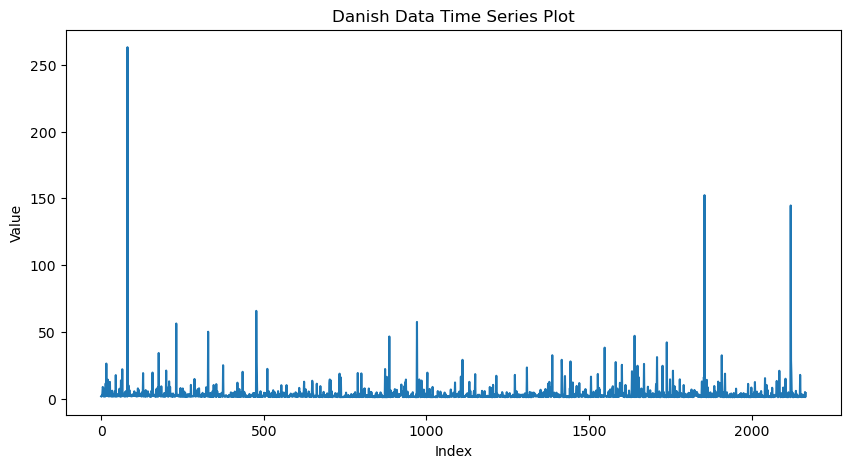

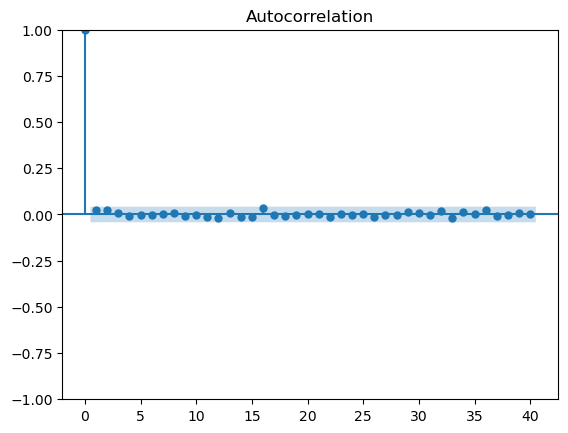

ADF Statistic: -45.41423974728117
p-value: 0.0
Critical Values: {'1%': -3.433372653139527, '5%': -2.8628753016111688, '10%': -2.567480848042739}
The series is stationary (reject the null hypothesis).
Ljung-Box Test Results:
      lb_stat  lb_pvalue
25  8.075594   0.999451


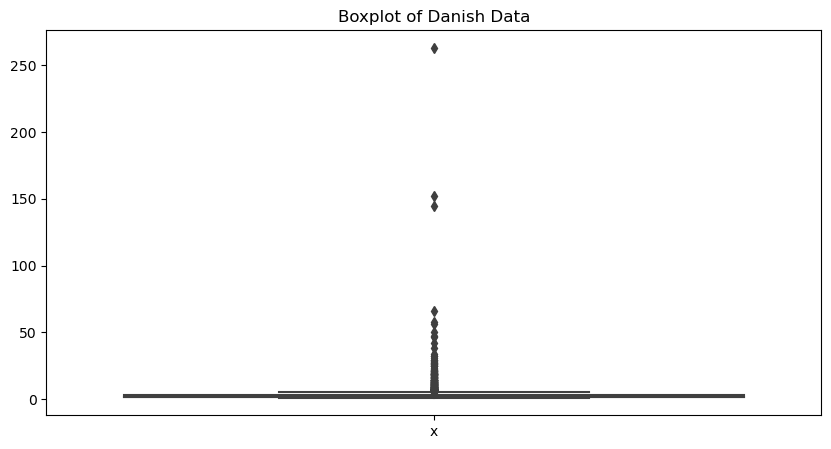

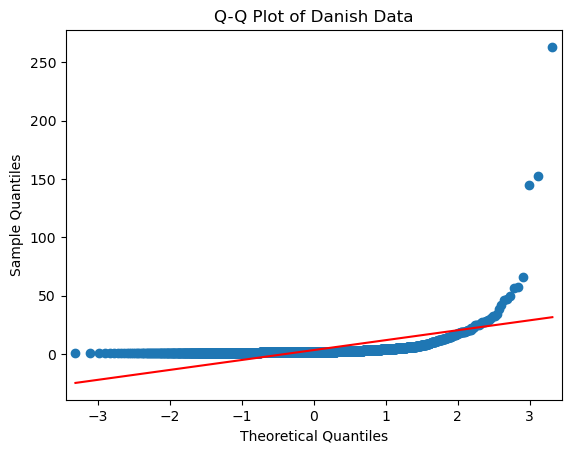

Shapiro-Wilk Test Statistic: 0.19689857959747314
p-value: 0.0
The data is not normally distributed (reject the null hypothesis).


In [5]:
length_danish = len(df_danish)
print("Length of danish:", length_danish)

# 2. Attributes in Python: If 'danish' is a pandas Series with DateTimeIndex
if isinstance(df_danish.index, pd.DatetimeIndex):
    print("First 10 timestamps:", df_danish.index[:10])
else:
    print("The data does not have a datetime index.")

# 3. Plot the data (time series plot)
plt.figure(figsize=(10, 5))
plt.plot(df_danish)
plt.title('Danish Data Time Series Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

# 4. ACF Plot (Autocorrelation Function)
sm.graphics.tsa.plot_acf(df_danish, lags=40)
plt.show()

# 5. Augmented Dickey-Fuller Test (ADF Test for stationarity)
adf_test = ts.adfuller(df_danish)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

# Low p-value means unit-root hypothesis rejected, series is stationary
if adf_test[1] < 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is not stationary (fail to reject the null hypothesis).")

# 6. Ljung-Box test for stationarity
ljung_box_test = sm.stats.acorr_ljungbox(df_danish, lags=[25], return_df=True)
print("Ljung-Box Test Results:\n", ljung_box_test)

# 7. Check if the data is Gaussian

# Boxplot of 'danish'
plt.figure(figsize=(10, 5))
sns.boxplot(df_danish)
plt.title("Boxplot of Danish Data")
plt.show()

# Q-Q Plot
sm.qqplot(df_danish.sort_values(by='x'), line='s')
plt.title("Q-Q Plot of Danish Data")
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(df_danish)
print("Shapiro-Wilk Test Statistic:", shapiro_test[0])
print("p-value:", shapiro_test[1])

# Interpretation of Shapiro-Wilk test
if shapiro_test[1] < 0.05:
    print("The data is not normally distributed (reject the null hypothesis).")
else:
    print("The data is normally distributed (fail to reject the null hypothesis).")

### 2.Exploratoty data analysis of the Peak Over Threshold

Make different EDA plot to check if a POT analysis is relevant and adapted. You can try :
- Quantile plot for Pareto model (you can read and use the `pareto_plot` function provided in the beggining of this notebook) _Warning : takes a numpy.array as input_
- Mean residual life plot (you can read and use the `plot_mean_residual_life` from `pyextremes` library : https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/) _Warning : takes a pandas.Series as input_
- Hill plot (you can read and use the `hill` function provided in the beggining of this notebook) _Warning : takes a numpy.array as input_

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 9.453e+05
Date:                Fri, 11 Oct 2024   Prob (F-statistic):               0.00
Time:                        10:43:24   Log-Likelihood:                 3939.2
No. Observations:                1954   AIC:                            -7874.
Df Residuals:                    1952   BIC:                            -7863.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1527      0.001    147.484      0.0

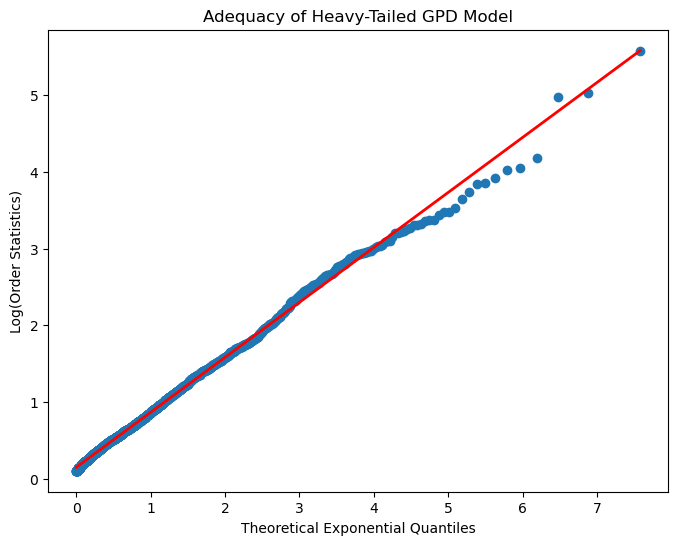

In [6]:
data = df_danish.iloc[:,0].to_numpy()
pareto_plot(data, threshold=None)

The excendances over the quantile of order $p=0.1$ seems to fit quite well to a Pareto distribution 

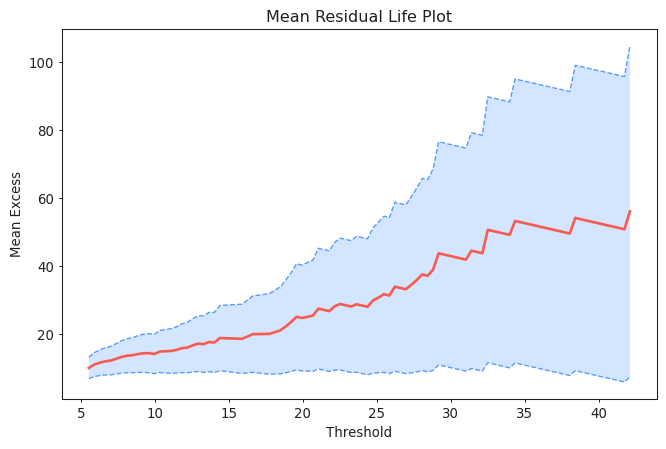

In [7]:
plot_mean_residual_life(df_danish.iloc[:,0])
plt.title("Mean Residual Life Plot")
plt.xlabel("Threshold")
plt.ylabel("Mean Excess")
plt.show()

The MRL plot seems to show that the threshold can be chosen between $5$ and $20$

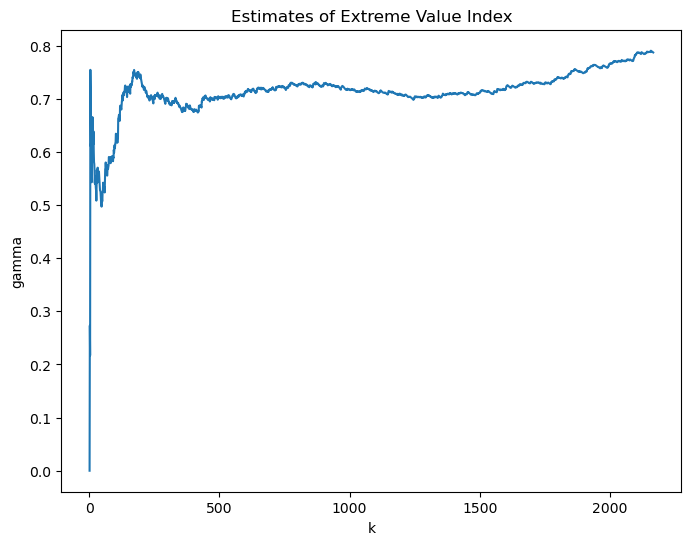

In [8]:
hh = hill(data, plot=True)

The Hill plot seems to have a wide range of stability with stable estimate of $\gamma$

### 3- Generalized Pareto Distribution fit

- Find a relevant threshold to fit your model (you can use the diagnosis you made in question 2), and also use `plot_parameter_stability` from `pyextremes` : https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/. _Beware : this librairy is designed to deal with time series : you may have to change the index to make it a time series (and adapt the `r` parameter which is the declustering windows)_ For isntance you could do : 
```
new_index = pd.to_datetime(df_danish.index)
df_danish.index = new_index
delta_declustering = df_danish.index[1] - df_danish.index[0]
```
- To fit a GPD : you can use `scipy.stats.genpareto.fit`: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genpareto.html :

```
# demo genpareto library
data_simu = stats.genpareto.rvs(c=0.5, loc=5, scale=10, size=10000, random_state=None)
xi_fit, mu_fit, sigma_fit = stats.genpareto.fit(data_simu)
print(xi_fit, mu_fit, sigma_fit)
```


(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

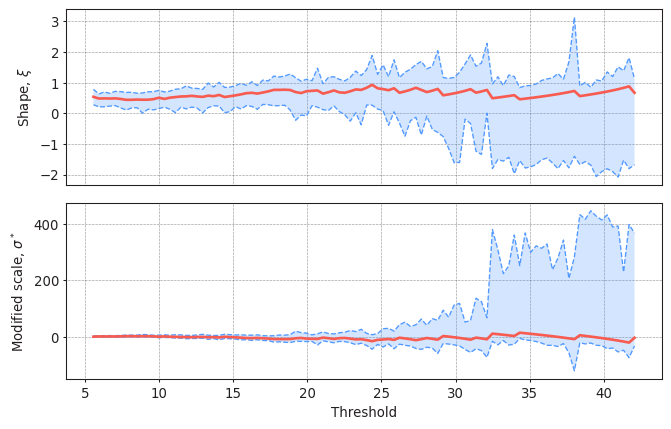

In [9]:
new_index = pd.to_datetime(df_danish.index)
df_danish.index = new_index
delta_declustering = df_danish.index[1] - df_danish.index[0]
alpha_confidence=0.95
plot_parameter_stability(df_danish.iloc[:,0],r=delta_declustering,alpha =alpha_confidence)

It looks like the threshold can be set at 10

In [10]:
# Make a GPD fit

u = 10
data = df_danish.iloc[:,0].to_numpy()
data_thresh = data[data>u] - u
xi_fit, mu_fit, sigma_fit = stats.genpareto.fit(data_thresh)
print(xi_fit, mu_fit, sigma_fit)

0.49903552465283263 0.011123470286386637 6.950057569580389


We got approximately the same value of $\xi$ than with other diagnosis plots : which is good news.

### 4- Compare the GPD fit with a GPD fitwith the $\xi = 0$ constraint

- First : recall the limit of the GPD density (or cdf) when $\xi \rightarrow 0$, you should find a known distribution
- Fit a GPD with $\xi = 0$ to the data
-  Compare both models (model $\mathcal{M}_0$ with constraint $\xi = 0$ and model $\mathcal{M}_1$ with free $\xi$). For this you could use an AIC based analysis, or use a test such as the likelihood ratio (see reminder below). Can you tell how relevant is it to have $\xi = 0$

__Reminder for the likelihood-ratio test__: Let $\mathcal{M}_1$ be a model, and $\mathcal{M}_0$ a subset model of $\mathcal{M}_1$ (which means that $\forall \theta_0 \in \Theta_0$, the parameter set of model $\mathcal{M}_0$, we have $ \theta_1 \in \Theta_1$ (the parameter set of model $\mathcal{M}_1$), such that $\theta_1 = (\theta_0,\theta^{(1)})$ ).
\newline
Then under $\mathbb{H}_0$ and suitable regularity conditions (we will suppose those conditions are met):
$$T:=2\ln(\frac{\sup_{\theta \in \Theta_1}\mathcal{L(\theta)}\mid x_n}{\sup_{\theta \in \Theta_0}\mathcal{L(\theta)}\mid x_n}) \xrightarrow{n \rightarrow \infty, d} \chi_k^2 $$
with :

- $\sup_{\theta \in \Theta}\mathcal{L(\theta)}\mid x_n$ the maximum likelihood on the set $\Theta$, on $n$ observed values $x_n$
- $k = \dim(\Theta_1) - \dim(\Theta_0) $, the difference of degrees of liberty of the two models.

The GPD tends to an exponential distribution when $\xi \rightarrow 0$

To fit an exponential you can use scipy : 
```
import scipy
vars = scipy.stats.expon.rvs(loc=2, scale=5, size=10000, random_state=None)
scipy.stats.expon.fit(vars)
```

In [11]:
import scipy


u = 10
data = df_danish.iloc[:,0].to_numpy()
data_thresh = data[data>u] - u
mu_fit, sigma_fit = scipy.stats.expon.fit(data_thresh)
mu_fit, sigma_fit

(0.011123470522800716, 14.070652286988906)

In [12]:
# Make Likelihood ratio test

# Get sample of gpd fit
u = 10
data = df_danish.iloc[:,0].to_numpy()
data_thresh = data[data>u] - u
xi_fit, mu_fit, sigma_fit = stats.genpareto.fit(data_thresh)
print("GPD fit",xi_fit, mu_fit, sigma_fit)
list_log_lik_gpd_fit = [np.log(scipy.stats.genpareto.pdf(x, xi_fit, loc=mu_fit, scale=sigma_fit)) for x in data_thresh]
log_lik_gpd_fit = np.sum(list_log_lik_gpd_fit)

# Get sample of exponential fit
u = 10
data = df_danish.iloc[:,0].to_numpy()
data_thresh = data[data>u] - u
mu_fit, sigma_fit = scipy.stats.expon.fit(data_thresh)
list_log_lik_expo_fit = [np.log(scipy.stats.expon.pdf(x, loc=mu_fit, scale=sigma_fit)) for x in data_thresh]
log_lik_expo_fit = np.sum(list_log_lik_expo_fit)

T_stat = 2*(log_lik_gpd_fit-log_lik_expo_fit)
print("T_stat",T_stat)
p_value = scipy.stats.chi2.sf(T_stat, df=1)
print("p_value",p_value)

GPD fit 0.49903552465283263 0.011123470286386637 6.950057569580389
T_stat 44.974177203249496
p_value 1.9964992098833282e-11


The p-value is very low : we can reject the null hypothesis: thus the model with $\xi = 0$ (exponential excesses) is much less relevant than the one with free $\xi$ (gpd excesses)

### 5- Return levels

- Give an estimate for the 50 - years return level based on the estimated parameters and give another estimate with the Weissman estimator.

In [13]:
# With estimated parameters

# Caution : these are not daily data but only the largest insurance claim
total_nb_days = 365.25*10+10*30 # from Thursday 3rd January 1980 until Monday 31st December 1990

# Recall the fit of the GPD
u = 10
data = df_danish.iloc[:,0].to_numpy()
data_thresh = data[data>u] - u
xi_fit, mu_fit, sigma_fit = stats.genpareto.fit(data_thresh)
# print(xi_fit, mu_fit, sigma_fit)

# We make the approximation : proba of exceeding thresh : #days_claim/#total_days
proba_above_thresh = len(data_thresh)/total_nb_days

# We compute the estimated quantile
# p_above_thresh * (1-F(u_50)) = alpha_50_years
# (1-F(u_50)) = alpha_50_years/p_above_thresh
alpha_50_years = 1/(50*365)
u_50 = u + sigma_fit/xi_fit*((alpha_50_years/proba_above_thresh)**(-xi_fit)-1)
print(u_50)

306.6432670998811


In [14]:
# With the Weissman estimator
p = (alpha_50_years/proba_above_thresh)
print("p = ", p) # We need the kth order statistic such that p < k/n << 1
print("4/n = ", 4/len(data_thresh))
# Let's choose k = 4
k = 4
data_thresh_sorted = sorted(data_thresh)
x_4 = data_thresh[-k]
u_50_weiss = u + x_4*(k/(len(data_thresh)*p))**(xi_fit)
print("u_50_weiss", u_50_weiss)

p =  0.0019869297473922333
4/n =  0.03669724770642202
u_50_weiss 587.0784677389698


### 6- Probability of high quantiles
Give an estimator of the probability of occurrence over a year of an excess above:
- Twice the maximum observed on the considered period
- the maximum observed on the considered period

Compare with the empirical estimator.

In [15]:
# proba of occurence over a year of twice the maximum observed on the considered period

twice_max_obs = 2*np.max(data_thresh)
# Multiply proba_above_thresh by 365 because we want to have the proba of being over threshold over a year
proba_twice = 365*proba_above_thresh*(1+xi_fit*(twice_max_obs/sigma_fit))**(-1/xi_fit) 
print(proba_twice)

0.007108242686507663


In [16]:
# proba of occurence over a year of the maximum observed on the considered period

max_obs = np.max(data_thresh)
# Multiply proba_above_thresh by 365 because we want to have the proba of being over threshold over a year
proba_max = 365*proba_above_thresh*(1+xi_fit*(max_obs/sigma_fit))**(-1/xi_fit)
print(proba_max)

0.027039774693826905


In [17]:
# Compare with the empirical estimator :

# For twice the max
proba_twice_emp = 0/total_nb_days*365
print("proba_twice_emp = ", proba_twice_emp)

# For the max
proba_max_emp = 1/total_nb_days*365
print("proba_max_emp = ", proba_max_emp)

proba_twice_emp =  0.0
proba_max_emp =  0.09234661606578115


We can see that the empirical estimator is highly uncertain (it only uses a fraction of the information, instead of trying to extrapolate all the information of the tail of the distribution)

# Annual maxima of sea level at Port Pirie (Australia)
This dataset is made of daily sea level recording for a period of 48 years

### 1- Make the same data analysis as in previous exercice

In [18]:
df_portpirie = pd.read_csv("portpirie.csv")
df_portpirie

x
0   4.03
1   3.83
2   3.65
3   3.88
4   4.01
..   ...
60  4.08
61  3.90
62  3.88
63  3.94
64  4.33

[65 rows x 1 columns]

Length of portpirie: 65
The data does not have a datetime index.


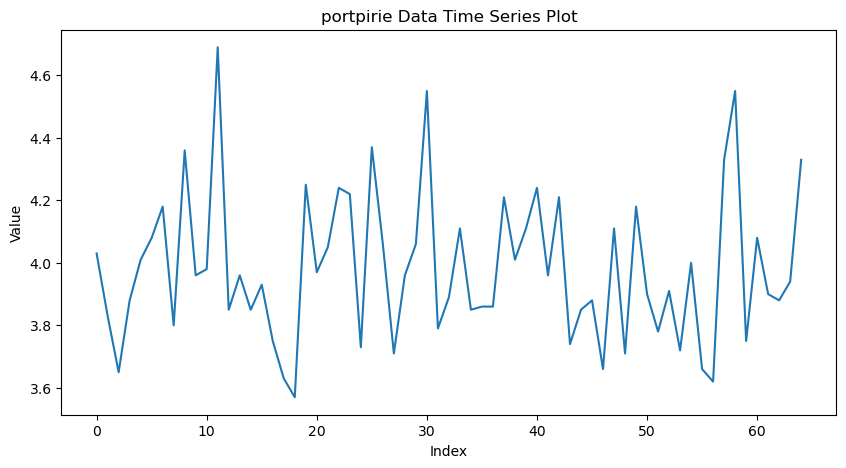

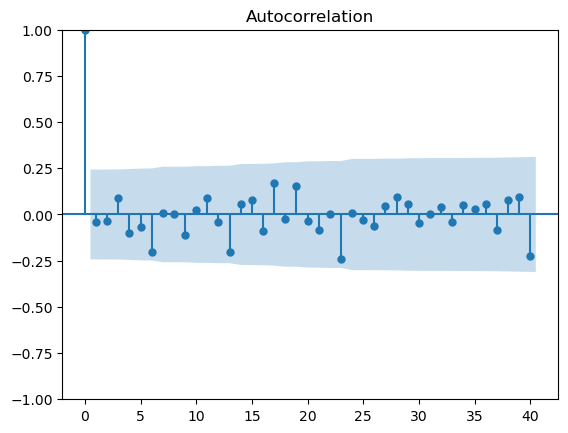

ADF Statistic: -8.055385633977902
p-value: 1.6980392796551207e-12
Critical Values: {'1%': -3.53692771987915, '5%': -2.907887369384766, '10%': -2.591493291015625}
The series is stationary (reject the null hypothesis).
Ljung-Box Test Results:
       lb_stat  lb_pvalue
25  23.405394   0.553904


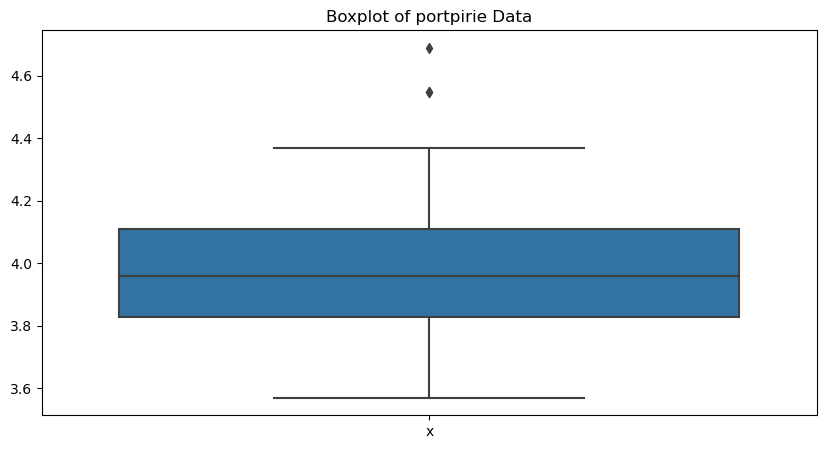

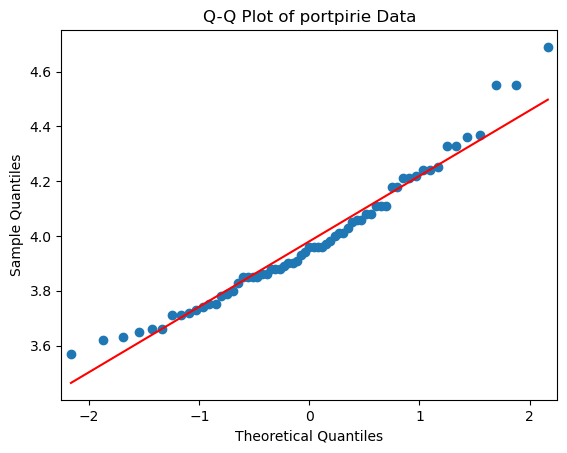

Shapiro-Wilk Test Statistic: 0.9611479043960571
p-value: 0.03936007246375084
The data is not normally distributed (reject the null hypothesis).


In [19]:
length_portpirie = len(df_portpirie)
print("Length of portpirie:", length_portpirie)

# 2. Attributes in Python: If 'portpirie' is a pandas Series with DateTimeIndex
if isinstance(df_portpirie.index, pd.DatetimeIndex):
    print("First 10 timestamps:", df_portpirie.index[:10])
else:
    print("The data does not have a datetime index.")

# 3. Plot the data (time series plot)
plt.figure(figsize=(10, 5))
plt.plot(df_portpirie)
plt.title('portpirie Data Time Series Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

# 4. ACF Plot (Autocorrelation Function)
sm.graphics.tsa.plot_acf(df_portpirie, lags=40)
plt.show()

# 5. Augmented Dickey-Fuller Test (ADF Test for stationarity)
adf_test = ts.adfuller(df_portpirie)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

# Low p-value means unit-root hypothesis rejected, series is stationary
if adf_test[1] < 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is not stationary (fail to reject the null hypothesis).")

# 6. Ljung-Box test for stationarity
ljung_box_test = sm.stats.acorr_ljungbox(df_portpirie, lags=[25], return_df=True)
print("Ljung-Box Test Results:\n", ljung_box_test)

# 7. Check if the data is Gaussian

# Boxplot of 'portpirie'
plt.figure(figsize=(10, 5))
sns.boxplot(df_portpirie)
plt.title("Boxplot of portpirie Data")
plt.show()

# Q-Q Plot
sm.qqplot(df_portpirie.sort_values(by='x'), line='s')
plt.title("Q-Q Plot of portpirie Data")
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(df_portpirie)
print("Shapiro-Wilk Test Statistic:", shapiro_test[0])
print("p-value:", shapiro_test[1])

# Interpretation of Shapiro-Wilk test
if shapiro_test[1] < 0.05:
    print("The data is not normally distributed (reject the null hypothesis).")
else:
    print("The data is normally distributed (fail to reject the null hypothesis).")

### 2 - Try to fit a GEV, and then a GEV with $\xi = 0$ constraint 
- to fit a GEV you can use the genextreme package __Caution : look at the documentation : the shape parameter $c$ is such that $c = -\xi$__ : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html
- you can use the gumbel function provided in the Util part
- Could you give ideas on which model to chose ?

-0.05010534785328627 3.874758730628963 0.19803814023673208


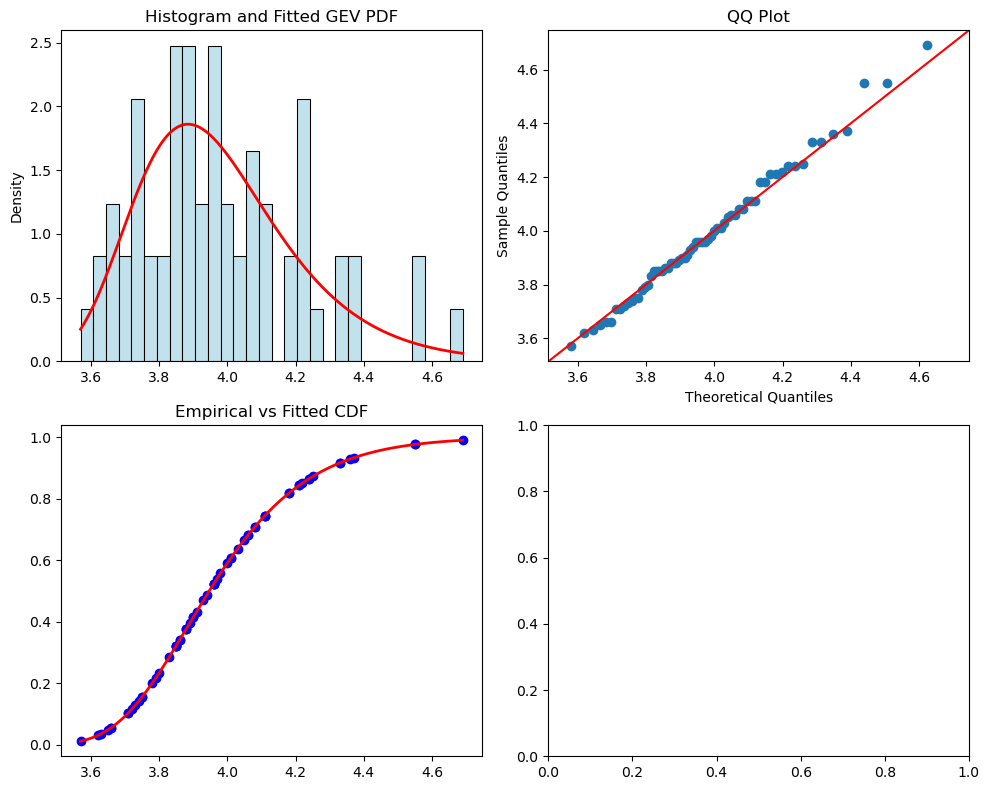

In [20]:
data = df_portpirie.to_numpy().reshape(-1)

# First try to fit a regular GEV : Caution : look
c_fit, mu_fit, scale_fit = genextreme.fit(data)
xi_fit = -c_fit
print(xi_fit, mu_fit, scale_fit)

# We can check the results of the fit
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Histogram and GEV PDF
ax1 = axes[0, 0]
sns.histplot(data, bins=30, kde=False, stat="density", ax=ax1, color="lightblue")
x = np.linspace(min(data), max(data), 1000)
gev_pdf = genextreme.pdf(x, c_fit, loc=mu_fit, scale=scale_fit)
ax1.plot(x, gev_pdf, 'r-', lw=2, label="GEV PDF")
ax1.set_title("Histogram and Fitted GEV PDF")

# QQ Plot
ax2 = axes[0, 1]
sm.qqplot(np.sort(data), dist=genextreme(c_fit, loc=mu_fit, scale=scale_fit), line='45', ax=ax2)
ax2.set_title("QQ Plot")

# Probability plot (CDF)
ax3 = axes[1, 0]
gev_cdf = genextreme.cdf(np.sort(data), c_fit, loc=mu_fit, scale=scale_fit)
ax3.plot(np.sort(data), gev_cdf, 'bo', label="Empirical")
ax3.plot(x, genextreme.cdf(x, c_fit, loc=mu_fit, scale=scale_fit), 'r-', lw=2, label="GEV CDF")
ax3.set_title("Empirical vs Fitted CDF")

plt.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.089e+04
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           2.69e-72
Time:                        13:49:14   Log-Likelihood:                 168.55
No. Observations:                  65   AIC:                            -333.1
Df Residuals:                      63   BIC:                            -328.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8690      0.003   1536.469      0.0

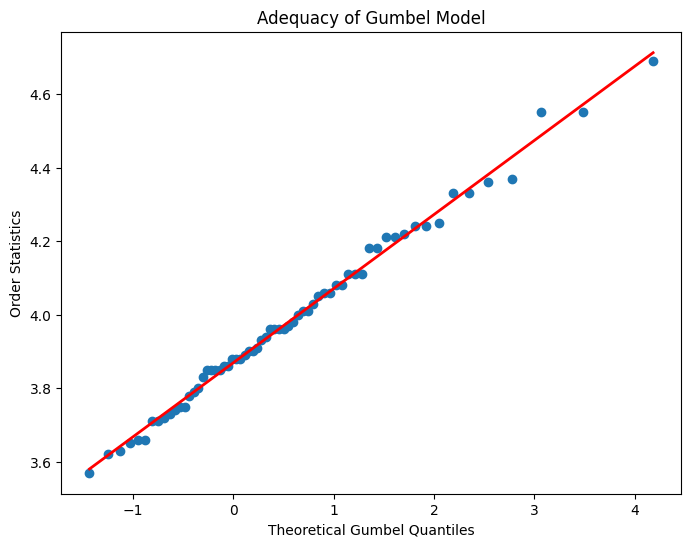

The Gumbel model seems to fit quite well too.

The Gumbel model seems to fit well, and has 1 parameter less to fit : it can be clever to use this simpler model. (We could use a BIC or an AIC criteria to make the decision)

### 3- Give an estimate of the one thousand year return level with both models

# Rain data in south England
1- Make the same Exploratory Data Analysis as in the previous questions to check if the data has seasonality, and can be modeled by a gaussain

2- Propose two methods to estimate the 100 year return level  based respectively on an analysis of block-maxima and of peaks over threshold.

3- Compare the estimations obtained in both models.

In [108]:
df_rain = pd.read_csv("rain.csv")
df_rain

x
0      0.0
1      2.3
2      1.3
3      6.9
4      4.6
...    ...
17526  1.3
17527  0.0
17528  1.8
17529  3.8
17530  5.1

[17531 rows x 1 columns]